In [2]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
filename = "models/phi-3-16.gguf"
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained(filename, device_map="auto")
from micrlhf.sampling import sample
from transformers import AutoTokenizer
import jax
# tokenizer = load_tokenizer(filename)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

/home/neverix/.cache/pypoetry/virtualenvs/micrlhf-progress-a058ydGG-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
/home/neverix/.cache/pypoetry/virtualenvs/micrlhf-progress-a058ydGG-py3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
!git clone https://github.com/roeehendel/icl_task_vectors data/itv
import glob
import json
import os
tasks = {}
for g in glob.glob("data/itv/data/**/*.json"):
    tasks[os.path.basename(g).partition(".")[0]] = json.load(open(g))

/home/neverix/.pyenv/versions/3.12.3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


fatal: destination path 'data/itv' already exists and is not an empty directory.


In [5]:
tasks.keys()

dict_keys(['location_continent', 'football_player_position', 'location_religion', 'location_language', 'person_profession', 'location_country', 'country_capital', 'person_language', 'singular_plural', 'present_simple_past_simple', 'antonyms', 'plural_singular', 'present_simple_past_perfect', 'present_simple_gerund', 'en_it', 'it_en', 'en_fr', 'en_es', 'fr_en', 'es_en'])

In [29]:
from micrlhf.llama import LlamaBlock
from micrlhf.sampling import sample, jit_wrapper
get_resids = llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda i, x:
    pz.nn.Sequential([
        pz.de.TellIntermediate.from_config(tag=f"resid_pre_{i}"),
        x
    ])
)
get_resids = pz.de.CollectingSideOutputs.handling(get_resids, tag_predicate=lambda x: x.startswith("resid_pre"))
get_resids_call = jit_wrapper.Jitted(get_resids)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 9/9 [02:04<00:00, 13.81s/it]


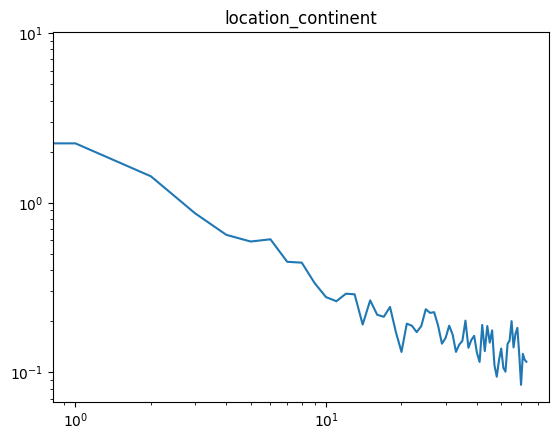

100%|██████████| 9/9 [01:48<00:00, 12.03s/it]t]


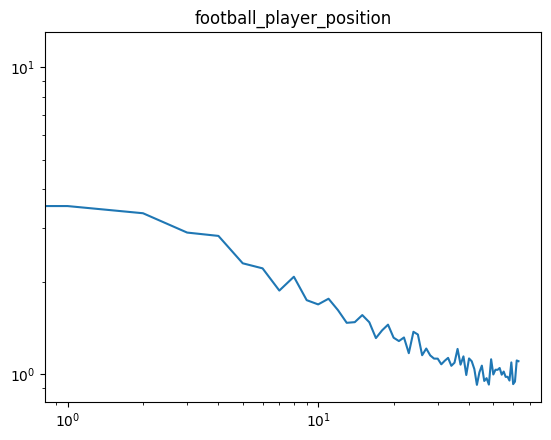

100%|██████████| 9/9 [01:45<00:00, 11.74s/it]t]


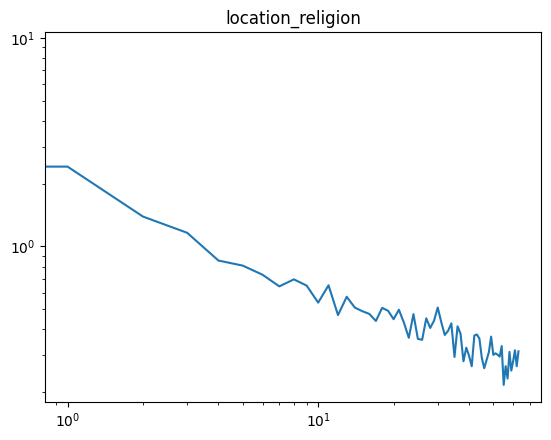

100%|██████████| 9/9 [01:45<00:00, 11.76s/it]t]


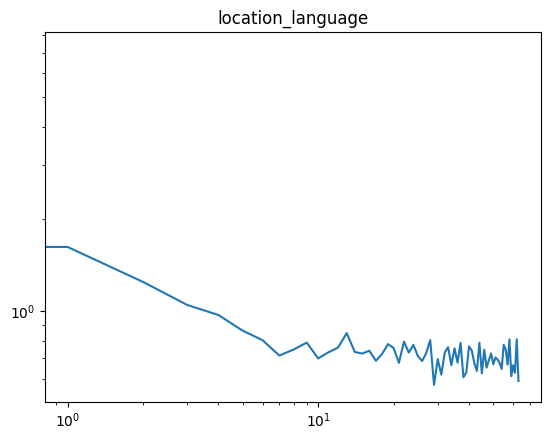

100%|██████████| 9/9 [01:46<00:00, 11.80s/it]t]


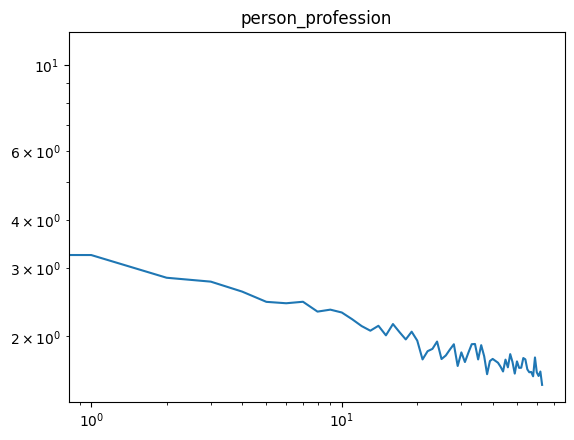

100%|██████████| 9/9 [01:46<00:00, 11.79s/it]t]


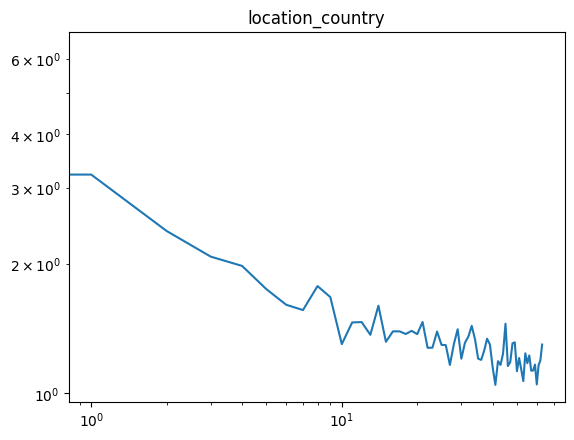

100%|██████████| 9/9 [01:45<00:00, 11.74s/it]t]


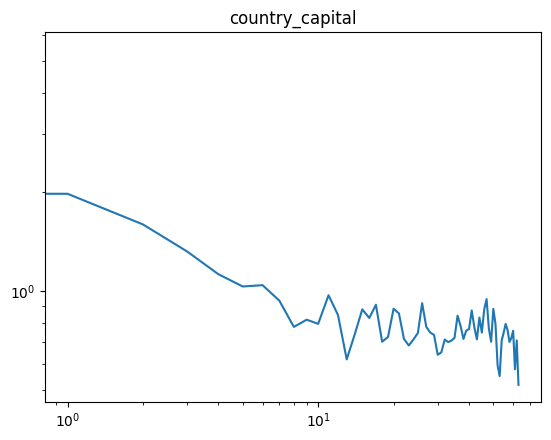

100%|██████████| 9/9 [01:49<00:00, 12.13s/it]t]


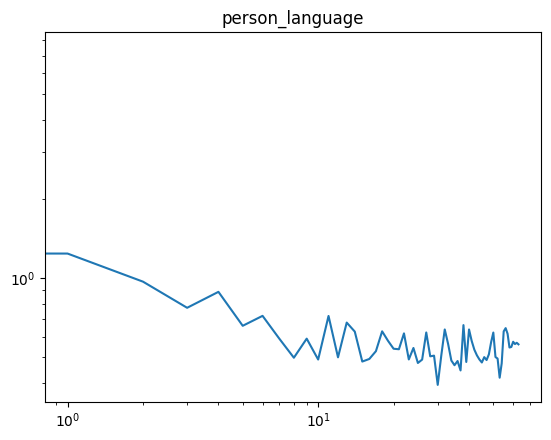

100%|██████████| 9/9 [01:47<00:00, 11.99s/it]t]


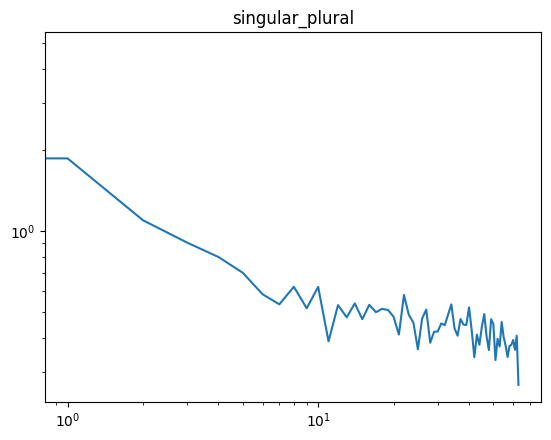

100%|██████████| 9/9 [01:46<00:00, 11.80s/it]t]


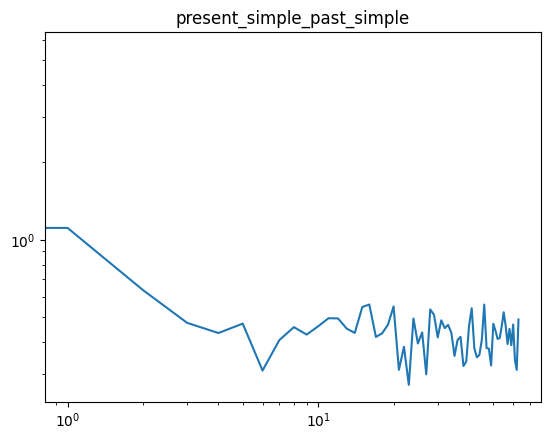

100%|██████████| 9/9 [01:43<00:00, 11.46s/it]it]


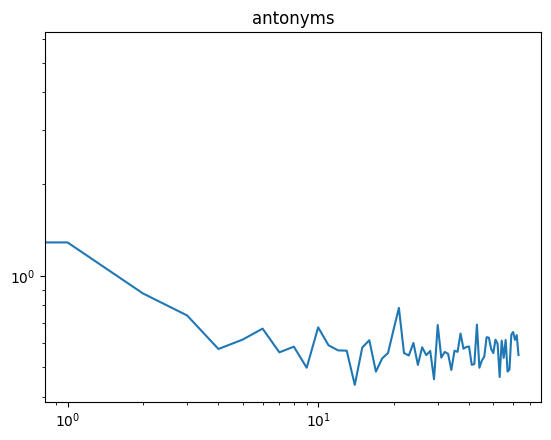

100%|██████████| 9/9 [01:43<00:00, 11.55s/it]it]


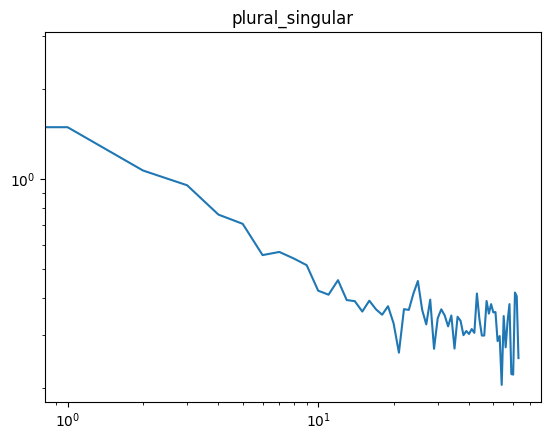

100%|██████████| 9/9 [01:44<00:00, 11.61s/it]it]


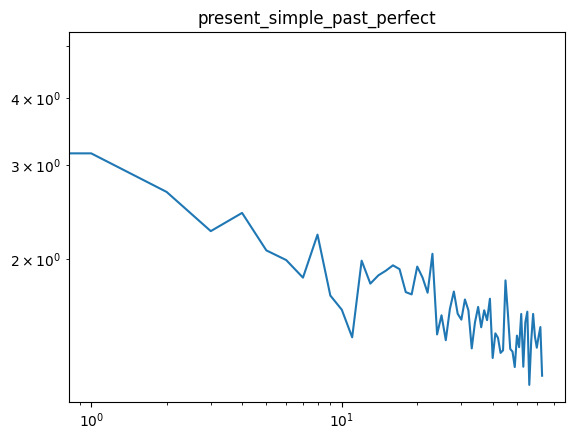

100%|██████████| 9/9 [01:46<00:00, 11.87s/it]it]


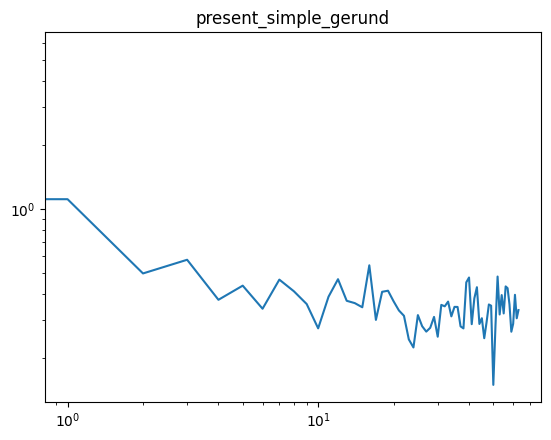

100%|██████████| 9/9 [01:46<00:00, 11.88s/it]it]


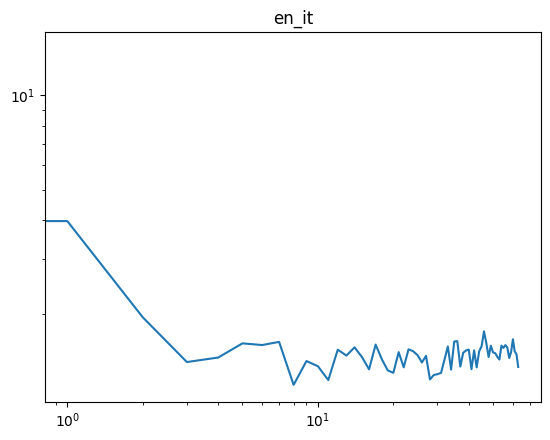

100%|██████████| 9/9 [01:44<00:00, 11.56s/it]it]


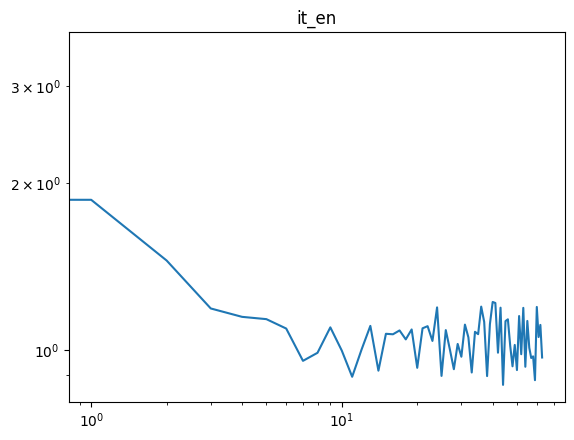

100%|██████████| 9/9 [01:45<00:00, 11.70s/it]it]


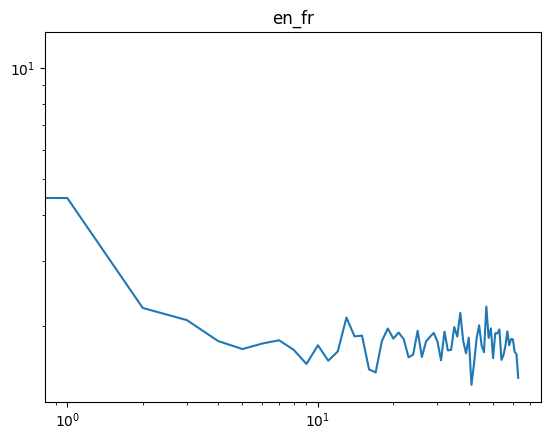

100%|██████████| 9/9 [01:45<00:00, 11.77s/it]it]


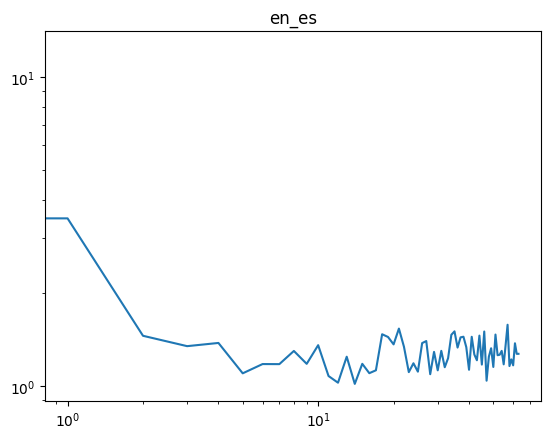

100%|██████████| 9/9 [01:46<00:00, 11.87s/it]it]


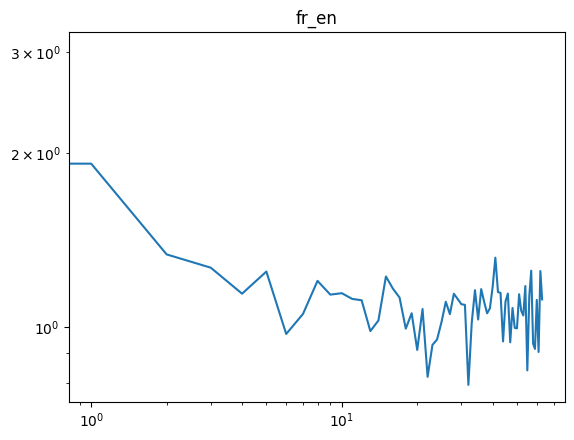

100%|██████████| 9/9 [01:45<00:00, 11.70s/it]it]


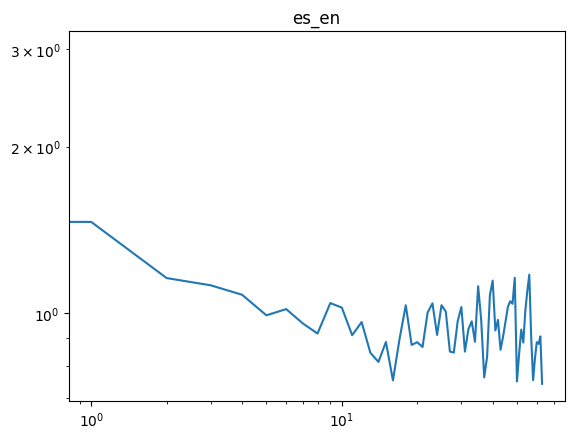

100%|██████████| 20/20 [35:46<00:00, 107.34s/it]


In [57]:
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
import jax.numpy as jnp
import numpy as np
import random


def form_tokens(task, n_shots):
    prompt = ["<user>Here is a rule:"]
    for s, t in random.sample(list(tasks[task].items()), n_shots):
        prompt.append(f"{s} -> {t}")
    prompt = "\n".join(prompt)
    tokens = tokenizer.encode(prompt)
    arrows = [i for i, e in enumerate(tokens) if e == 1599]  # arrow
    newlines = [i + tokens[i:].index(13) for i in arrows[:-1]] + [len(tokens)]  # newline
    segments = list(zip(arrows, newlines))
    return tokens, segments

def tok_segments_to_input(batch, max_length=128):
    tokens = [t[:max_length] for t, _ in batch]
    tokens = [t + [tokenizer.pad_token_id] * (max_length - len(t)) for t in tokens]
    token_array = jnp.asarray(tokens)
    token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
    token_array = pz.nx.wrap(token_array, "batch", "seq").untag("batch").tag("batch")
    inputs = llama.inputs.from_basic_segments(token_array)
    return inputs


# n_few_shots, batch_size, max_seq_len = 64, 64, 512
n_few_shots, batch_size, max_seq_len = 64, 64, 1024
for task in tqdm(tasks):
    shot_logprobs = [[] for _ in range(n_few_shots)]
    for _ in trange(9):
        tokens = [form_tokens(task, n_few_shots) for _ in range(batch_size)]
        inputs = tok_segments_to_input(tokens, max_length=max_seq_len)
        logits, resids = get_resids_call(inputs)
        logits = jax.nn.log_softmax(logits.unwrap("batch", "seq", "vocabulary"), axis=-1)
        for i, (t, s) in enumerate(tokens):
            for j, (a, b) in enumerate(s):
                if b >= max_seq_len:
                    continue
                logprob = float(-jnp.take_along_axis(logits[i, a:b-1], jnp.array(t[a+1:b], dtype=jnp.int32)[:, None], 1).sum())
                shot_logprobs[j].append(logprob)
    shot_logprobs = list(map(np.mean, shot_logprobs))
    plt.plot(shot_logprobs)
    plt.xscale("log")
    plt.yscale("log")
    plt.title(task)
    plt.show()

In [3]:
texts, cached_base = sample(llama, tokenizer, "<user>Here is a rule:\nIllinois -> Chicago\nWashington ->", batch_size=1, do_sample=False, return_model=True)
texts

100%|██████████| 64/64 [00:34<00:00,  1.86it/s]


['<s> <user>Here is a rule:\nIllinois -> Chicago\nWashington -> D.C.\n\nNow, based on the above rule, what is the correct transformation for "California -> ?"\n\n\n<|assistant<|im_sep|>The rule seems to be']